In [1]:
import os
import torch
import pandas as pd
from PIL import Image
from torchvision.transforms import functional as F

class StarStreakDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, csv_path, transforms=None):
        self.image_dir = image_dir
        self.data = pd.read_csv(csv_path)
        self.image_names = self.data['image'].unique()
        self.transforms = transforms
        self.label_map = {'star': 0, 'streak': 1}

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        name, ext = os.path.splitext(image_name)
        img_path = os.path.join(self.image_dir, image_name)
        img = Image.open(img_path).convert("RGB")

        records = self.data[self.data['image'] == image_name]

        boxes = []
        labels = []

        for _, row in records.iterrows():
            x1 = row['bbox_x']
            y1 = row['bbox_y']
            x2 = x1 + row['bbox_width']
            y2 = y1 + row['bbox_height']
            boxes.append([x1, y1, x2, y2])
            labels.append(self.label_map[row['object_type']])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_names)


In [2]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
from torchvision import transforms as T
import os


DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# ---- Transforms ----
def get_transform():
    return T.Compose([
        T.ToTensor()
    ])

# ---- Dataset ----
dataset = StarStreakDataset("TiledImages", "tiled_annotations.csv", get_transform())
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
print(f"Total images: {len(dataset)}")


Total images: 855


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split    

def compute_metrics(model, data_loader, iou_threshold=0.5, visualize_fp=False):
    model.eval()
    all_preds = []
    all_targets = []
    all_labels = []
    all_preds_cls = []

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating"):
            images = [img.to(DEVICE) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                gt_boxes = targets[i]["boxes"].cpu()
                gt_labels = targets[i]["labels"].cpu()
                pred_boxes = output["boxes"].cpu()
                pred_labels = output["labels"].cpu()
                scores = output["scores"].cpu()

                # Collect for metrics
                all_labels.extend(gt_labels.numpy())
                all_preds_cls.extend(pred_labels.numpy())

                # ---- False Positive Visualization ----
                if visualize_fp:
                    ious = torchvision.ops.box_iou(pred_boxes, gt_boxes)
                    is_fp = []
                    for j in range(len(pred_boxes)):
                        max_iou = ious[j].max().item() if len(gt_boxes) > 0 else 0
                        is_fp.append(max_iou < iou_threshold)

                    # Draw FP boxes
                    import matplotlib.patches as patches
                    import torchvision.transforms.functional as F
                    img_np = images[i].permute(1, 2, 0).cpu().numpy()
                    fig, ax = plt.subplots(1)
                    ax.imshow(img_np)
                    for k, box in enumerate(pred_boxes):
                        x1, y1, x2, y2 = box
                        color = 'r' if is_fp[k] else 'g'
                        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                                 linewidth=2, edgecolor=color, facecolor='none')
                        ax.add_patch(rect)
                    ax.set_title("Red: False Positives, Green: True Positives")
                    plt.show()

    # ---- Confusion Matrix ----
    cm = confusion_matrix(all_labels, all_preds_cls)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
    plt.xlabel("Predicted")
    plt.ylabel("Ground Truth")
    plt.title("Confusion Matrix")
    plt.show()

    # ---- Metrics ----
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    precision = np.mean(tp / (tp + fp + 1e-6))
    recall = np.mean(tp / (tp + fn + 1e-6))
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    print(f"\n📊 Precision: {precision:.4f}")
    print(f"📊 Recall:    {recall:.4f}")
    print(f"📊 F1 Score:  {f1:.4f}")


In [7]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm


BATCH_SIZE = 4
NUM_CLASSES = 3 # Change this based on your dataset (e.g., 2 for {background, object})
NUM_EPOCHS = 1

train_indices = indices[:-10]
val_indices = indices[-10:]
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# ---- Model Setup ----
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)
model.to(DEVICE)

# ---- Optimizer & Scheduler ----
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# ---- Tracking ----
train_losses, val_losses, lrs = [], [], []

# ---- Training & Validation ----
for epoch in range(NUM_EPOCHS):
    print(f"\n🔁 Epoch {epoch+1}/{NUM_EPOCHS}")
    model.train()
    epoch_train_loss = 0.0

    for images, targets in tqdm(train_loader, desc="Training"):
        images = [img.to(DEVICE) for img in images]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_train_loss += losses.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    lrs.append(optimizer.param_groups[0]["lr"])
    print(f"✅ Train Loss: {avg_train_loss:.4f} | LR: {lrs[-1]:.6f}")
    # Evaluation & FP Visualization
torch.save(model.state_dict(), "fasterrcnn_star_streak_processed_3.pth")
print("📦 Model saved to 'fasterrcnn_star_streak_processed.pth'.")


            # ---- Validation ----
# ---- Save Model ----




🔁 Epoch 1/1


Training: 100%|██████████| 212/212 [33:11<00:00,  9.39s/it]


✅ Train Loss: 0.0163 | LR: 0.005000
📦 Model saved to 'fasterrcnn_star_streak_processed.pth'.


In [5]:
torch.save(model.state_dict(), "fasterrcnn_star_streak_processed.pth")
print("📦 Model saved to 'fasterrcnn_star_streak_processed.pth'.")

📦 Model saved to 'fasterrcnn_star_streak_processed.pth'.


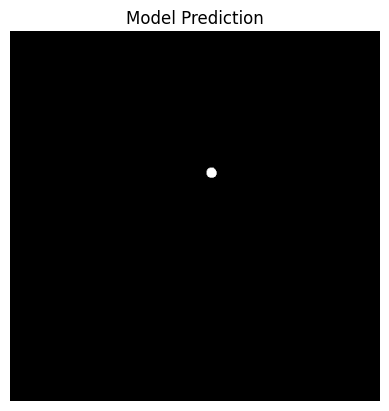

In [7]:
model.eval()
with torch.no_grad():
    sample_img, _ = dataset[0]
    prediction = model([sample_img.to(DEVICE)])[0]

plot_image_with_boxes(sample_img, prediction, title="Model Prediction")


In [ ]:
import os
import cv2
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms as T
from PIL import Image
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ---- Paths ----
image_dir = "Processed"  # Directory with TIFF files
output_dir = Path("annotated_output_rcnn_new_patched")
output_dir.mkdir(exist_ok=True)

# ---- Device ----
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# ---- Load Model ----
num_classes = 2  # star and streak
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load("fasterrcnn_star_streak_Processed.pth", map_location=device))
model.to(device)
model.eval()

# ---- Transform ----
transform = T.Compose([
    T.ToTensor()
])

# ---- Label Map ----
label_map = {0: "star", 1: "streak"}

# ---- Patch Parameters ----
patch_size = 512
overlap = 64  # overlap between patches to avoid missing objects at boundaries

def split_into_patches(image, patch_size=512, overlap=64):
    """Split image into overlapping patches"""
    width, height = image.size
    patches = []
    positions = []  # (x1, y1) coordinates of each patch in original image
    
    stride = patch_size - overlap
    
    for y in range(0, height, stride):
        for x in range(0, width, stride):
            # Ensure we don't go beyond image boundaries
            x_end = min(x + patch_size, width)
            y_end = min(y + patch_size, height)
            
            # Adjust starting position if we're at the end
            if x_end == width:
                x = max(0, x_end - patch_size)
            if y_end == height:
                y = max(0, y_end - patch_size)
                
            patch = image.crop((x, y, x_end, y_end))
            patches.append(patch)
            positions.append((x, y))
    
    return patches, positions

def combine_predictions(predictions, positions, original_size, confidence_threshold=0.1):
    """Combine predictions from patches into original image coordinates"""
    combined_boxes = []
    combined_labels = []
    combined_scores = []
    
    for (x_offset, y_offset), pred in zip(positions, predictions):
        # Filter by confidence
        mask = pred['scores'] >= confidence_threshold
        boxes = pred['boxes'][mask]
        labels = pred['labels'][mask]
        scores = pred['scores'][mask]
        
        # Adjust box coordinates to original image space
        adjusted_boxes = boxes.clone()
        adjusted_boxes[:, 0] += x_offset  # x1
        adjusted_boxes[:, 1] += y_offset  # y1
        adjusted_boxes[:, 2] += x_offset  # x2
        adjusted_boxes[:, 3] += y_offset  # y2
        
        # Clip boxes to image boundaries
        
        combined_boxes.append(adjusted_boxes)
        combined_labels.append(labels)
        combined_scores.append(scores)
    
    # Concatenate all predictions
    if len(combined_boxes) > 0:
        combined_boxes = torch.cat(combined_boxes, dim=0)
        combined_labels = torch.cat(combined_labels, dim=0)
        combined_scores = torch.cat(combined_scores, dim=0)
        
        # Apply non-maximum suppression to remove overlapping boxes
        keep = torchvision.ops.nms(combined_boxes, combined_scores, iou_threshold=0.3)
        
        return {
            'boxes': combined_boxes[keep],
            'labels': combined_labels[keep],
            'scores': combined_scores[keep]
        }
    else:
        return {
            'boxes': torch.empty((0, 4)),
            'labels': torch.empty((0,), dtype=torch.int64),
            'scores': torch.empty((0,))
        }

# ---- Inference + Annotation ----
confidence_threshold = 0.1

for image_name in os.listdir(image_dir):
    if not image_name.lower().endswith((".tif", ".tiff", ".png", ".jpg")):
        continue

    img_path = os.path.join(image_dir, image_name)
    img = Image.open(img_path).convert("RGB")
    original_size = img.size
    
    # Split into patches
    patches, positions = split_into_patches(img, patch_size, overlap)
    
    # Process each patch
    patch_predictions = []
    for patch in patches:
        img_tensor = transform(patch).unsqueeze(0).to(device)
        
        # Inference
        with torch.no_grad():
            predictions = model(img_tensor)[0]
        
        patch_predictions.append(predictions)
    
    # Combine predictions
    combined_pred = combine_predictions(patch_predictions, positions, original_size, confidence_threshold)
    
    # Convert to OpenCV image for annotation
    cv_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    
    for box, label, score in zip(combined_pred['boxes'], combined_pred['labels'], combined_pred['scores']):
        if score < confidence_threshold:
            continue

        x1, y1, x2, y2 = map(int, box)
        label_name = label_map[label.item()]
        color = (0, 255, 0) if label_name == "star" else (255, 0, 0)  # Green for star, Blue for streak

        cv2.rectangle(cv_img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(cv_img, f"{label_name} {score:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Save annotated image
    save_path = output_dir / f"annotated_{image_name.rsplit('.', 1)[0]}.jpg"
    cv2.imwrite(str(save_path), cv_img)
    print(f"✅ Saved: {save_path}")

✅ Saved: annotated_output_rcnn_new_patched\annotated_Raw_Observation_001_Set1_binary.jpg
✅ Saved: annotated_output_rcnn_new_patched\annotated_Raw_Observation_002_Set1_binary.jpg
✅ Saved: annotated_output_rcnn_new_patched\annotated_Raw_Observation_003_Set1_binary.jpg
✅ Saved: annotated_output_rcnn_new_patched\annotated_Raw_Observation_004_Set1_binary.jpg
✅ Saved: annotated_output_rcnn_new_patched\annotated_Raw_Observation_005_Set1_binary.jpg
✅ Saved: annotated_output_rcnn_new_patched\annotated_Raw_Observation_006_Set1_binary.jpg
✅ Saved: annotated_output_rcnn_new_patched\annotated_Raw_Observation_007_Set1_binary.jpg
✅ Saved: annotated_output_rcnn_new_patched\annotated_Raw_Observation_008_Set1_binary.jpg
✅ Saved: annotated_output_rcnn_new_patched\annotated_Raw_Observation_009_Set1_binary.jpg
✅ Saved: annotated_output_rcnn_new_patched\annotated_Raw_Observation_010_Set1_binary.jpg


KeyboardInterrupt: 

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image_with_boxes(img, target, title="Image with Boxes"):
    """
    img: Tensor image (C, H, W)
    target: dict with 'boxes' and 'labels'
    """
    img = img.permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C) for matplotlib

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for box, label in zip(target['boxes'], target['labels']):
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"{label.item()}", color='white', bbox=dict(facecolor='red', edgecolor='none', boxstyle='round,pad=0.2'))

    plt.title(title)
    plt.axis('off')
    plt.show()


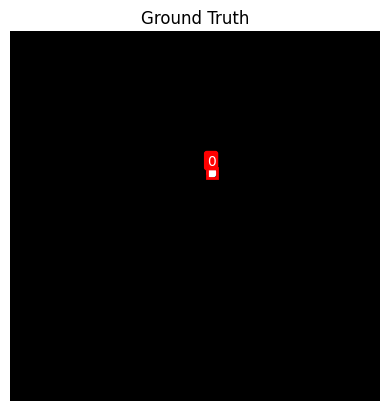

In [8]:
sample_img, sample_target = dataset[0]  # First image
plot_image_with_boxes(sample_img, sample_target, title="Ground Truth")
